# Redis::Cluster::Fast benchmark

Run benchmark script and make result as a csv file.

```bash
perl ./examples/benchmark-simple.pl > /tmp/bench.csv
```

- loop
    - 100000
- commands
    - set
    - get
- clients
    - Redis::Cluster::Fast
    - Redis::ClusterRider
- redis server
    - localhost docker containers


# read results
## percentile table

In [77]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/tmp/bench.csv', header=None)

# Group by the first column
grouped = df.groupby(0)[1]

# Calculate percentiles for the second column
percentiles = grouped.apply(lambda x: np.percentile(x, [50, 80, 95, 99, 100]))

# Convert percentiles to a readable DataFrame
result = percentiles.apply(pd.Series)
result.columns = ['P50', 'P80', 'P95', 'P99', 'P100']

# Print the result
header = "+--------------------------------+-------+-------+-------+-------+-------+"
print(header)
print("| Operation                      | P50   | P80   | P95   | P99   | P100  |")
print(header)

for index, row in result.iterrows():
    print(f"| {index:<30} | {row['P50']:<5.3f} | {row['P80']:<5.3f} | {row['P95']:<5.3f} | {row['P99']:<5.3f} | {row['P100']:<5.3f} |")

print(header)

+--------------------------------+-------+-------+-------+-------+-------+
| Operation                      | P50   | P80   | P95   | P99   | P100  |
+--------------------------------+-------+-------+-------+-------+-------+
| get_pp                         | 0.028 | 0.033 | 0.039 | 0.049 | 0.955 |
| get_xs                         | 0.021 | 0.023 | 0.026 | 0.045 | 0.445 |
| get_xs_pipeline                | 0.014 | 0.014 | 0.016 | 0.019 | 0.437 |
| get_xs_pipeline_batched_100    | 0.003 | 0.004 | 0.005 | 0.073 | 0.398 |
| set_pp                         | 0.028 | 0.032 | 0.036 | 0.049 | 2.013 |
| set_xs                         | 0.021 | 0.024 | 0.027 | 0.047 | 0.539 |
| set_xs_pipeline                | 0.014 | 0.016 | 0.017 | 0.020 | 0.345 |
| set_xs_pipeline_batched_100    | 0.003 | 0.004 | 0.005 | 0.073 | 0.308 |
+--------------------------------+-------+-------+-------+-------+-------+


## histograms


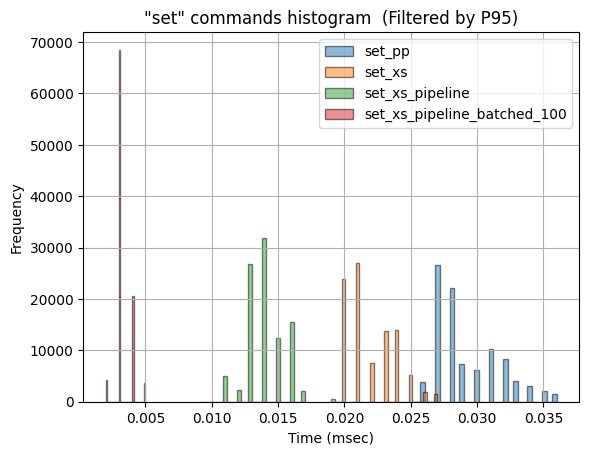

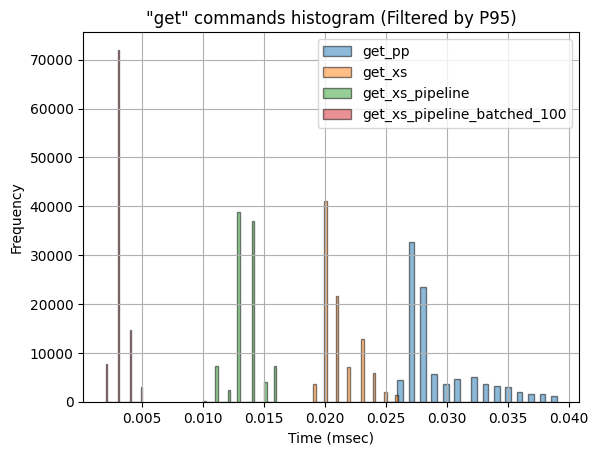

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('/tmp/bench.csv', header=None)

# Group by the first column
df.columns = ['name', 'msec']
grouped = df.groupby('name')['msec']

# Filter each group to include only values <= 95th percentile
filtered_groups = grouped.apply(lambda x: x[x <= np.percentile(x, 95)])

# Split data into "set_" and "get_" groups
set_groups = filtered_groups[filtered_groups.index.get_level_values(0).str.startswith('set_')]
get_groups = filtered_groups[filtered_groups.index.get_level_values(0).str.startswith('get_')]

# Plot histogram for "set_" labels
plt.figure()
for key, filtered_group in set_groups.groupby(level=0):
    plt.hist(filtered_group, bins=30, alpha=0.5, label=f'{key}', edgecolor='black')
plt.title('"set" commands histogram  (Filtered by P95)')
plt.xlabel('Time (msec)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram for "get_" labels
plt.figure()
for key, filtered_group in get_groups.groupby(level=0):
    plt.hist(filtered_group, bins=30, alpha=0.5, label=f'{key}', edgecolor='black')
plt.title('"get" commands histogram (Filtered by P95)')
plt.xlabel('Time (msec)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()